In [195]:
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import time
%matplotlib inline

## A simple example -- Birth and Death process using discrete time stepping
This example simulates birth and death process drawing from a exponential distribution 

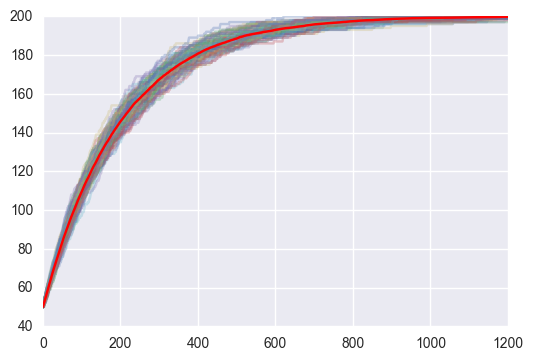

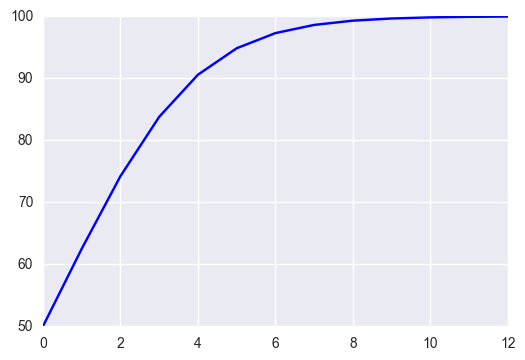

In [80]:
P = 100000  # maximum population size, this parameter is not used. (or set to infinity)
a = .5  # birth rate
b = .005  # death rate

N = 100 # number of realisation
T = 1200 # number of time steps
x = np.zeros((N, T))
init_val = 50
for i in range(N): # number of realisation
    x[i][0] = init_val
    for t in range(T - 1): # time steps
        if 0 < x[i][t]:
            # Is there a birth?
            birth = np.random.rand() <= a*x[i][t]
            # Is there a death?
            death = np.random.rand() <= b*x[i][t]
            # We update the population size.
            x[i][t+1] = x[i][t] + 1*birth - 1*death
        # The evolution stops if we reach $0$ or $N$.
        else:
            x[i][t+1] = x[i][t]

    #print x[:20]


plt.plot(x.transpose(), alpha=0.3)
plt.plot(x.mean(axis=0), color='r')
plt.figure()
y = np.zeros(T)
y[0] = init_val
for t in range(T-1):
    y[t+1] = y[t] * (1 + a - b * y[t])
plt.plot(y[:int(-1.0 / a * np.log(0.001))], color='b')

## A simple example -- Birth - death in as continuous time markov process

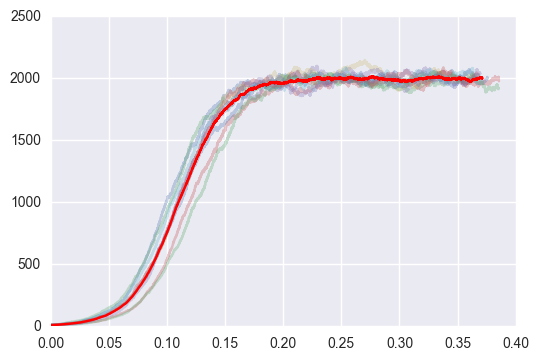

In [194]:
# Parameters
tau = 0.001 # time interval
gamma = 0.05 # birth rate
kappa = 0.005 # death rate 

t_inf = 50 # "time at infinity" 
n_max = int(t_inf / tau) # number simulated time generation
num_sim = 10 # number realisations
N_init = 10

record = np.zeros((num_sim, n_max))
time_array = np.zeros((num_sim, n_max))
record[:, 0] = np.ones(num_sim) * N_init

for i in range(num_sim):
    for t in range(n_max -1):
        if record[i][t] > 0:
            dn = (kappa * record[i][t]) ** 2
            bn = gamma * record[i][t]
            death_time = random_exp_time(dn / tau, 1)
            birth_time = random_exp_time(bn / tau, 1)
            if death_time < birth_time: #death occur
                record[i][t + 1] = record[i][t] -1
                time_array[i][t + 1] = time_array[i][t] + death_time
            else:
                record[i][t + 1] = record[i][t] +1
                time_array[i][t + 1] = time_array[i][t] + birth_time
        else:
            continue

#for i in range(num_sim):
#    plt.plot(time[i], record[i])
plt.plot(time_array.transpose(), record.transpose(), alpha=0.3)
plt.plot(time_array.mean(axis=0), record.mean(axis=0), color='r')

In [350]:
def random_exp_time(rate=1, *n):
    """
    Return a random vector with n entries, 
    each beingn a waiting time which is exponentially
    distributed.
    """
    if rate == 0:
        return np.inf
    return -1.0/rate * np.log(np.random.rand(*n))

def get_min_time(rand_time_matrix):
    argmin = np.unravel_index(rand_time_matrix.argmin(), rand_time_matrix.shape)
    return argmin, rand_time_matrix[argmin]

def plot_series(series, ax=None, alpha=1, title='', color=None):
    ax.plot(series, alpha=alpha, color=color)
    if title:
        ax.set_title("%s \nMean: %.2f Median: %.2f Std: %.2f" 
                     % (title, np.mean(series), np.median(series), np.std(series)))
    return ax

def rvs_generator(n, p, h):
    rand_vec = np.random.rand(n)
    p_left = p / (1.0 + h)
    p_right = p * h / (1.0 + h)
    move_prob = np.greater(p_left + p_right, rand_vec)
    move_left_prob = np.greater(p_left, rand_vec)
    return move_prob - 2 * move_prob * move_left_prob

def get_equilibrium_time2(series, min_points = 50):
    series = np.array(series)
    mean = np.mean(series)
    deviation = np.sqrt((series - mean)**2)
    mean_deviation = np.mean(deviation)
    std_deviation = np.std(deviation)
    for i in range(len(series) - min_points):
        window = deviation[i: i + min_points]
        window_mean = np.mean(window)
        #print i, window_mean, mean_deviation, std_deviation
        if np.abs(window_mean - mean_deviation) < std_deviation:
            print "Equitime: %i" %i
            return i + min_points
    return min_points

def get_equilibrium_time(series, min_points = 50):
    series = np.array(series)
    mean = np.mean(series)
    std = np.std(series)
    for i in range(len(series)):
        window_mean = np.mean(series[:i])
        if abs(window_mean - mean) < 0.5 * std:
            return max(i, min_points)
    return min_points
        
        
def compute_bins(series):
    """
    Friedman-Diaconis rule of thumb for histogram bin number
    """
    iqr = stats.iqr(series)
    n = series.size
    bins = (series.max() - series.min()) / (2 * iqr * n ** (-1/3.0))
    print "iqr, n, bins, max, min"
    print iqr, n, bins, series.max(), series.min(), (np.isnan(bins) or np.isinf(bins))
    if np.isnan(bins) or np.isinf(bins):
        return 10 # return default
    return int(bins)

class Simulate_Continuous(object):
    def __init__(self, num_init_agents=1000, 
                 birth_rate=None, death_rate=None, mutation_rate=None, 
                 selection_penalty=None, num_generation=None,  
                 rv_sample_generator=None, init_dist=None, 
                 t_inf=None, tau=0.01, delta=0.01):
        self.birth_rate = birth_rate
        self.death_rate = death_rate
        self.mutation_rate = mutation_rate
        self.selection_penalty = selection_penalty
        self.rv_sample_generator = rv_sample_generator
        self.t_inf = t_inf
        self.tau = tau
        self.delta = delta
        if num_generation:
            self.num_generation = num_generation
        elif t_inf:
            self.num_generation = int(t_inf / tau)
        self.num_init_agents = num_init_agents
        if type(init_dist) != np.ndarray:
            self.init_dist = np.zeros(self.num_init_agents)
        else:
            self.init_dist = self.init_dist        
        self.realisations = []
    
    def realise(self):
        agents = self.init_dist
        population_n = [agents.size]
        pheno_mean = [agents.mean()]
        pheno_median = [np.median(agents)]
        for n in range(self.num_generation):
            current_pop_size = population_n[-1]
            if current_pop_size == 0:
                population_n.append(agents.size)
                pheno_mean.append(agents.mean())
                pheno_median.append(np.median(agents))
                continue 
            rand_time = np.zeros((3, current_pop_size)) # birth, death, mutate
            for agent_index in range(current_pop_size):
                bn = (self.birth_rate * current_pop_size 
                      - self.selection_penalty * (self.delta * agents[agent_index])**2)
                rand_time[0][agent_index] = random_exp_time(bn / self.tau, 1)
            dn = self.death_rate * current_pop_size
            rand_time[1] = random_exp_time(dn / self.tau, current_pop_size)
            rand_time[2] = random_exp_time(self.mutation_rate / self.tau, current_pop_size)
            argmin, min_time = get_min_time(rand_time)
            event, agent_index = argmin
            if event == 0: # birth
                agents = np.append(agents, agents[agent_index])
            elif event == 1: # death
                agents = np.delete(agents, agent_index)
            elif event == 2: # mutate
                agents[agent_index] += self.rv_sample_generator(1)
            population_n.append(agents.size)
            pheno_mean.append(agents.mean())
            pheno_median.append(np.median(agents))
        self.realisations.append({"agents":agents, "population_n":population_n,
                                 "pheno_mean":pheno_mean, "pheno_median":pheno_median})
        
    def add_realisation(self, n):
        for i in range(n):
            np.random.seed(int(time.time()))
            self.realise()
        return 
    
    def report_realisation(self, realisation):
        fig, axes = plt.subplots(4, 1, figsize = (7, 4 * 7))
        agents = realisation["agents"]
        population_n = realisation["population_n"]
        equi_mean = agents.mean()
        equi_num_agents = agents.size
        equi_median = np.median(agents)
        equi_std = np.std(agents)
        if equi_num_agents == 0:
            extinction_time = np.max(np.array(population_n).nonzero()) +1
            print "Extinction occurred at generation: %i" % extinction_time
        else:
            axes[0].hist(realisation["agents"], bins=compute_bins(realisation["agents"]))
            axes[0].set_title("Equilibrium Phenotype distribution\nMean: %.2f Median: %.2f Std: %.2f Total: %s"
                              % (equi_mean, equi_median, equi_std, equi_num_agents))
            xmin, xmax = axes[0].get_xlim()
            ax0_xaxis = np.linspace(xmin, xmax, num=100)
            axes[0].plot(ax0_xaxis, stats.norm.pdf(ax0_xaxis, loc=equi_mean, scale=equi_std) * equi_num_agents)
        plot_series(population_n, ax=axes[1], title="nth generation population size")
        axes[1].plot(axes[1].get_xlim(), np.ones(2) * np.mean(population_n))
        plot_series(realisation["pheno_mean"], ax=axes[2], title="nth generation phenotype mean")
        plot_series(realisation["pheno_median"], ax=axes[3], title="nth generation phenotype median")
        return fig, axes
    
    def report_avg_realisation(self):
        num_realisation = len(self.realisations)
        print "Number of realisations: %i" % num_realisation
        if num_realisation == 0:
            return 
        elif num_realisation == 1:
            return self.report_realisation(self.realisations[0])
        agents_n = []
        extinction_time = []
        for item in self.realisations:
            if 0 in item['population_n']:
                extinction_time.append(item['population_n'].index(0))
            else:
                agents_n.append(item["agents"])
        
        num_extinction = len(extinction_time)
        if num_extinction > 0:
            p_extinct = float(num_extinction) / num_realisation
            avg_ext_time = np.mean(extinction_time)
            print ("%i extinction event out of %i realisation\np_extinct ~ %.2f\navg_ext_time: %.2f" 
                   % (num_extinction, num_realisation,p_extinct, avg_ext_time))
        fig, axes = plt.subplots(4, 2, figsize = (7 * 2, 4 * 7))
        if agents_n:
            agents_n = np.concatenate(agents_n)
            equi_mean = agents_n.mean()
            equi_num_agents = agents_n.size
            equi_median = np.median(agents_n)
            equi_std = np.std(agents_n)
            equi_iqr = stats.iqr(agents_n)
            
            axes[0][0].hist(agents_n, bins=compute_bins(agents_n))
            axes[0][0].set_title("Equilibrium Phenotype distribution\nMean: %.2f Median: %.2f Std: %.2f Total: %s"
                              % (equi_mean, equi_median, equi_std, equi_num_agents))
            sns.distplot(agents_n, ax=axes[0][1])
            xmin, xmax = axes[0][0].get_xlim()
            ax0_xaxis = np.linspace(xmin, xmax, num=100)
            axes[0][1].plot(ax0_xaxis, stats.norm.pdf(ax0_xaxis, loc=equi_mean, scale=equi_std), color='g')
            axes[0][1].plot(ax0_xaxis, stats.cauchy.pdf(ax0_xaxis, loc=equi_median, scale=equi_iqr), color='r')
        
        
        mult_population_n = np.concatenate([[item["population_n"]] for item in self.realisations])
        eq_time_pop = get_equilibrium_time(gaussian_filter1d(mult_population_n.mean(axis=0), sigma=5))
        plot_series(mult_population_n.transpose(), alpha=0.3, ax=axes[1][0])
        plot_series(mult_population_n.mean(axis=0), alpha=1, color='r', ax=axes[1][0], 
                    title='nth generation population')
        plot_series(mult_population_n.transpose()[:eq_time_pop, :], alpha=0.3, ax=axes[1][1])
        plot_series(mult_population_n.mean(axis=0)[:eq_time_pop], alpha=1, color='r', ax=axes[1][1], 
                    title='nth generation population (cut off at estimated equilibrium time: gen %i)'%eq_time_pop)
        
        mult_pheno_mean = np.concatenate([[item["pheno_mean"]] for item in self.realisations])
        eq_time_mean = get_equilibrium_time(gaussian_filter1d(mult_pheno_mean.mean(axis=0), sigma=5))
        plot_series(mult_pheno_mean.transpose(), alpha=0.3, ax=axes[2][0])
        plot_series(mult_pheno_mean.mean(axis=0), alpha=1, color='r', ax=axes[2][0], 
                    title='nth generation phenotype mean')
        plot_series(mult_pheno_mean.transpose()[:eq_time_mean, :], alpha=0.3, ax=axes[2][1])
        plot_series(mult_pheno_mean.mean(axis=0)[:eq_time_mean], alpha=1, color='r', ax=axes[2][1], 
                    title='nth generation phenotype mean(cut off at estimated equilibrium time: gen %i)'%eq_time_mean)
        
        
        mult_pheno_median = np.concatenate([[item["pheno_median"]] for item in self.realisations])
        eq_time_median = get_equilibrium_time(gaussian_filter1d(mult_pheno_median.mean(axis=0), sigma=5))
        plot_series(mult_pheno_median.transpose(), alpha=0.3, ax=axes[3][0])
        plot_series(mult_pheno_median.mean(axis=0), alpha=1, color='r', ax=axes[3][0], 
                    title='nth generation phenotype median')
        plot_series(mult_pheno_median.transpose()[:eq_time_median, :], alpha=0.3, ax=axes[3][1])
        plot_series(mult_pheno_median.mean(axis=0)[:eq_time_median], alpha=1, color='r', ax=axes[3][1], 
                    title='nth generation phenotype median(cut off at estimated equilibrium time: gen %i)'%eq_time_median)
        return fig, axes

In [377]:
test_sim = Simulate_Continuous(num_init_agents=500, mutation_rate=0.1, 
                               birth_rate=0.01, 
                               death_rate=0.01, 
                               selection_penalty = 100,
                               num_generation=2000, 
                               rv_sample_generator=lambda n: rvs_generator(n, 1, 1), 
                               init_dist=None, 
                               tau=0.001, delta=0.01)

[473, 474, 473, 472, 473, 472, 471, 470, 471, 472, 471, 470, 469, 470, 469, 470, 469, 468, 469, 470]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[493, 494, 495, 494, 495, 496, 495, 496, 495, 496, 497, 496, 497, 498, 499, 500, 499, 500, 501, 502]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[510, 511, 510, 509, 508, 507, 508, 509, 508, 507, 508, 509, 508, 509, 510, 511, 512, 513, 514, 515]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Number of realisations: 6


/Users/elau1/Desktop/elau1/lifescience_usage/python_env/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in double_scalars


iqr, n, bins, max, min
0.0 3023 inf 2.0 -1.0 True


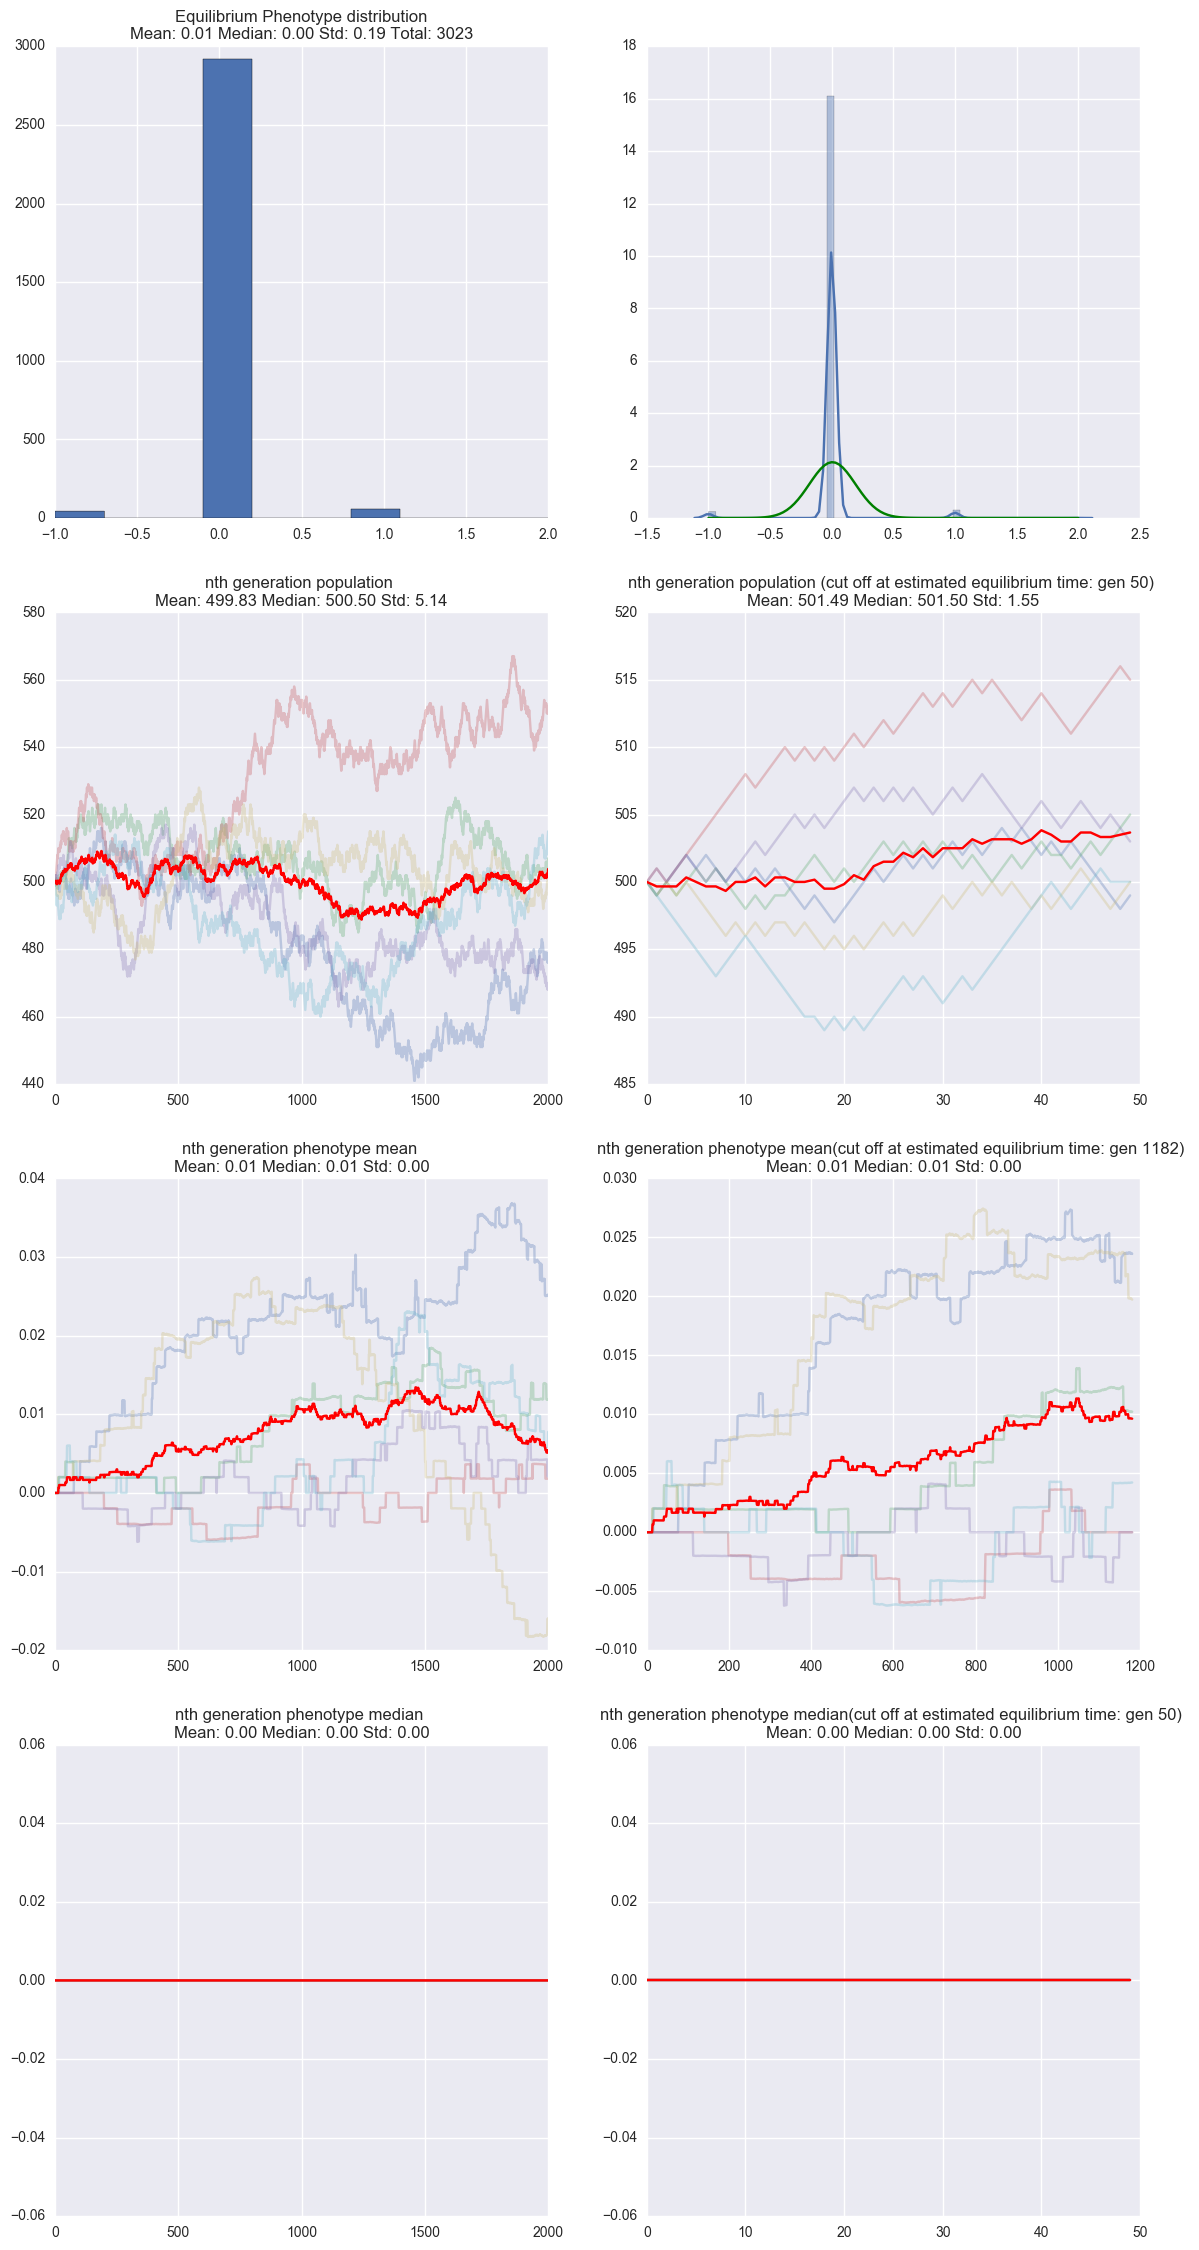

In [380]:
test_sim.add_realisation(10)
for realisation in test_sim.realisations[-3:]:
    print realisation["population_n"][-20:]
    print realisation["agents"][-10:]
a0 = test_sim.report_avg_realisation()

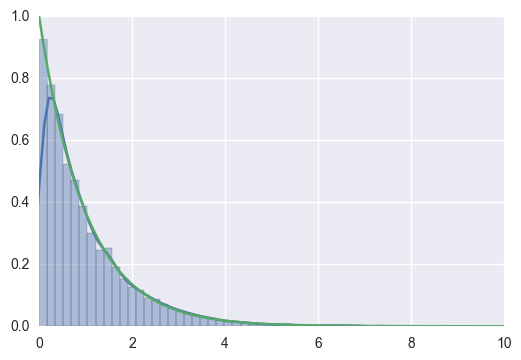

In [149]:
r = 1
N = 10000
ax = plt.subplot(111)
ax.set_xlim(0, 10.0/r)
sns.distplot(random_exp_time(r, N), ax=ax)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, num=1000)
ax.plot(x, r * np.exp(-r * x))